Heading:
📂 CSV to SQLite & ChromaDB Embedding Pipeline

Description:
This notebook:

Mounts Google Drive and locates CSV datasets.

Stores each CSV as a SQLite table for structured queries.

Sets up a persistent ChromaDB vector store.

Uses the BAAI/bge-m3 model to embed text columns (GPU-accelerated).

Saves embeddings with metadata into ChromaDB for semantic search.

Outcome:
Structured SQL database + vectorized text embeddings ready for hybrid RAG + SQL queries.

In [ ]:
# Install necessary packages
!pip install chromadb transformers torch tqdm --quiet

import os
import pandas as pd
import sqlite3
import torch
import chromadb
from transformers import AutoTokenizer, AutoModel
from google.colab import drive
from tqdm import tqdm

# ==============================
# 0️⃣ Mount Google Drive
# ==============================
drive.mount('/content/drive', force_remount=True)

# ==============================
# 1️⃣ Define paths
# ==============================
DATA_DIR = "/content/drive/MyDrive/archive"
DB_PATH = os.path.join(DATA_DIR, "olist_sqlite.db")
CHROMA_DB_PATH = os.path.join(DATA_DIR, "chroma_db")  # persistent ChromaDB folder on Drive
os.makedirs(CHROMA_DB_PATH, exist_ok=True)

# ==============================
# 2️⃣ List all CSV files
# ==============================
csv_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".csv")]
print("Found CSV files:", csv_files)

# ==============================
# 3️⃣ Store each CSV into SQLite
# ==============================
conn = sqlite3.connect(DB_PATH)
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(DATA_DIR, csv_file))
    table_name = os.path.splitext(csv_file)[0]
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(f"✅ Stored {csv_file} as table '{table_name}' in SQLite")
conn.close()

# ==============================
# 4️⃣ Setup persistent ChromaDB client
# ==============================
chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

# ==============================
# 5️⃣ Define embedding model wrapper with GPU batching
# ==============================
class BGEM3FlagModel:
    def __init__(self, model_name, use_fp16=False):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        if use_fp16:
            self.model.half()
        self.model.eval()
        if torch.cuda.is_available():
            self.model = self.model.to("cuda")

    def encode(self, texts, batch_size: int = 16, max_length: int = 512):
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
            batch = texts[i:i+batch_size]
            inputs = self.tokenizer(batch,
                                    return_tensors="pt",
                                    truncation=True,
                                    padding=True,
                                    max_length=max_length)
            if torch.cuda.is_available():
                inputs = {k: v.to("cuda") for k, v in inputs.items()}
            with torch.no_grad():
                output = self.model(**inputs)
            # Mean pooling
            emb = output.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(emb.tolist())
        return all_embeddings

embedding_model = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True)

# ==============================
# 6️⃣ Embed text columns and store in ChromaDB safely
# ==============================
CHROMA_BATCH_SIZE = 500  # must be <= max batch size of ChromaDB

for csv_file in csv_files:
    df = pd.read_csv(os.path.join(DATA_DIR, csv_file))
    table_name = os.path.splitext(csv_file)[0]

    # Create or get collection
    existing_collections = [c.name for c in chroma_client.list_collections()]
    if table_name in existing_collections:
        collection = chroma_client.get_collection(table_name)
    else:
        collection = chroma_client.create_collection(name=table_name)

    # Identify text/object columns
    text_cols = df.select_dtypes(include="object").columns.tolist()
    if not text_cols:
        print(f"⚠️ Skipping {csv_file}: no text columns")
        continue

    # Concatenate text columns
    texts_to_embed = df[text_cols].astype(str).agg(" ".join, axis=1).tolist()
    ids = df.index.astype(str).tolist()
    metadatas = df.to_dict(orient="records")

    # Compute embeddings in GPU batches
    embeddings = embedding_model.encode(texts_to_embed, batch_size=16, max_length=512)

    # Add to ChromaDB in safe batches
    for i in tqdm(range(0, len(texts_to_embed), CHROMA_BATCH_SIZE), desc=f"Adding '{table_name}' to ChromaDB"):
        batch_texts = texts_to_embed[i:i+CHROMA_BATCH_SIZE]
        batch_embeddings = embeddings[i:i+CHROMA_BATCH_SIZE]
        batch_ids = ids[i:i+CHROMA_BATCH_SIZE]
        batch_metadatas = metadatas[i:i+CHROMA_BATCH_SIZE]

        collection.add(
            documents=batch_texts,
            embeddings=batch_embeddings,
            metadatas=batch_metadatas,
            ids=batch_ids
        )

    print(f"✅ Stored embeddings for '{csv_file}' in ChromaDB collection '{table_name}'")

print("🎉 Stage 1 complete: SQLite at", DB_PATH, "and ChromaDB at", CHROMA_DB_PATH)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.2 MB/s eta 0

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]


Adding 'olist_customers_dataset' to ChromaDB: 100%|██████████| 199/199 [23:00<00:00,  6.94s/it]


✅ Stored embeddings for 'olist_customers_dataset.csv' in ChromaDB collection 'olist_customers_dataset'


Embedding batches: 100%|██████████| 6493/6493 [03:28<00:00, 31.19it/s]
Adding 'olist_order_payments_dataset' to ChromaDB: 100%|██████████| 208/208 [25:23<00:00,  7.33s/it]


✅ Stored embeddings for 'olist_order_payments_dataset.csv' in ChromaDB collection 'olist_order_payments_dataset'


Adding 'olist_order_items_dataset' to ChromaDB: 100%|██████████| 226/226 [25:46<00:00,  6.84s/it]


✅ Stored embeddings for 'olist_order_items_dataset.csv' in ChromaDB collection 'olist_order_items_dataset'


Embedding batches:   8%|▊         | 4928/62511 [03:11<74:58:13,  4.69s/it]

In [ ]:
import sqlite3

DB_PATH = "/content/drive/MyDrive/archive/olist_sqlite.db"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
conn.close()

print("✅ Tables stored in SQLite:")
for t in tables:
    print(" -", t[0])


✅ Tables stored in SQLite:
 - olist_customers_dataset
 - olist_order_payments_dataset
 - olist_order_items_dataset
 - olist_geolocation_dataset
 - olist_order_reviews_dataset
 - olist_sellers_dataset
 - product_category_name_translation
 - olist_products_dataset
 - olist_orders_dataset


In [ ]:
import chromadb

CHROMA_DB_PATH = "/content/drive/MyDrive/archive/chroma_db"
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

collections = client.list_collections()
print("✅ Collections stored in ChromaDB:")
for c in collections:
    print(f" - {c.name}")


✅ Collections stored in ChromaDB:
 - olist_order_payments_dataset
 - olist_customers_dataset
 - olist_order_items_dataset
 - olist_geolocation_dataset


In [ ]:
for c in collections:
    collection = client.get_collection(c.name)
    count = collection.count()
    print(f"{c.name}: {count} vectors")


olist_order_payments_dataset: 103886 vectors
olist_customers_dataset: 99441 vectors
olist_order_items_dataset: 112650 vectors
olist_geolocation_dataset: 0 vectors


🧠 Interactive SQL Agent with Conversation Memory

This section builds an AI-powered SQL Agent that allows users to query a SQLite database using natural language, without writing SQL manually.
It also maintains conversation context, enabling smooth follow-up questions like "plot that" or "show last query again".

In [ ]:
# INTERACTIVE SQL AGENT WITH CONVERSATION MEMORY
import os
import time
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain_google_genai import ChatGoogleGenerativeAI

# Configure API
os.environ["GOOGLE_API_KEY"] = ""#please insert your api key here

# Use Gemini 2.0 Flash
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    request_timeout=60
)

# Setup Database
sqlite_path = "/content/drive/MyDrive/archive/olist_sqlite.db"
db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")

# Create agent
agent = create_sql_agent(
    llm=llm,
    db=db,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=15,
    max_execution_time=60,
    early_stopping_method="generate"
)

# Conversation memory storage
conversation_history = []

def ask(question: str, delay: float = 2.0) -> str:
    """
    Ask a question with rate limit protection and conversation memory
    """
    # Add delay to avoid rate limits
    time.sleep(delay)

    # Build context from conversation history
    if conversation_history:
        context = "Previous conversation:\n"
        for i, (q, a) in enumerate(conversation_history[-3:], 1):  # Last 3 exchanges
            context += f"\nQ{i}: {q}\nA{i}: {a}\n"
        full_question = f"{context}\n\nCurrent question: {question}"
    else:
        full_question = question

    print(f"\n{'='*60}")
    print(f"🔍 Question: {question}")
    print(f"{'='*60}\n")

    try:
        result = agent.invoke({"input": full_question})
        answer = result['output']

        # Store in conversation memory
        conversation_history.append((question, answer))

        print(f"\n{'='*60}")
        print(f"✅ Answer:\n{answer}")
        print(f"{'='*60}\n")

        return answer

    except Exception as e:
        error_msg = str(e)
        if "rate limit" in error_msg.lower() or "quota" in error_msg.lower():
            print(f"\n⏳ Rate limit hit. Waiting 60 seconds...\n")
            time.sleep(60)
            return ask(question, delay=5)
        else:
            print(f"\n❌ Error: {error_msg}\n")
            return f"Error: {error_msg}"

def show_history():
    """Display conversation history"""
    if not conversation_history:
        print("\n📝 No conversation history yet.\n")
        return

    print("\n" + "="*60)
    print("📝 CONVERSATION HISTORY")
    print("="*60)
    for i, (q, a) in enumerate(conversation_history, 1):
        print(f"\n[{i}] Q: {q}")
        print(f"    A: {a[:200]}..." if len(a) > 200 else f"    A: {a}")
    print("\n" + "="*60 + "\n")

def clear_history():
    """Clear conversation history"""
    global conversation_history
    conversation_history = []
    print("\n✅ Conversation history cleared!\n")

# Display available tables
print("\n" + "="*60)
print("📊 AVAILABLE TABLES")
print("="*60)
for table in db.get_usable_table_names():
    print(f"  • {table}")
print("="*60 + "\n")

# Interactive loop
print("🤖 SQL Agent is ready! Type your questions below.")
print("Commands: 'history' to view chat, 'clear' to reset, 'quit' to exit\n")

while True:
    try:
        # Get user input
        user_input = input("💬 You: ").strip()

        # Handle commands
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\n👋 Goodbye!\n")
            break

        elif user_input.lower() == 'history':
            show_history()
            continue

        elif user_input.lower() == 'clear':
            clear_history()
            continue

        elif not user_input:
            print("⚠️  Please enter a question.\n")
            continue

        # Process question
        ask(user_input, delay=2)

    except KeyboardInterrupt:
        print("\n\n👋 Interrupted. Goodbye!\n")
        break
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}\n")


📊 AVAILABLE TABLES
  • olist_customers_dataset
  • olist_geolocation_dataset
  • olist_order_items_dataset
  • olist_order_payments_dataset
  • olist_order_reviews_dataset
  • olist_orders_dataset
  • olist_products_dataset
  • olist_sellers_dataset
  • product_category_name_translation

🤖 SQL Agent is ready! Type your questions below.
Commands: 'history' to view chat, 'clear' to reset, 'quit' to exit

💬 You: List top 5 products by sales quantity

🔍 Question: List top 5 products by sales quantity



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input:olist_customers_dataset, olist_geolocation_dataset, olist_order_items_dataset, olist_order_payments_dataset, olist_order_reviews_dataset, olist_orders_dataset, olist_products_dataset, olist_sellers_dataset, product_category_name_translationThe tables that seem most relevant to product sales are `olist_order_items_dataset` and `olist_products_dataset`. I should examine the schema of these tables.
Action: sql_

In [ ]:
# import os
# import time
# from langchain_community.agent_toolkits import create_sql_agent
# from langchain_community.utilities import SQLDatabase
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain.agents.agent_types import AgentType

# # Configure API
# os.environ["GOOGLE_API_KEY"] = ""

# # Use Gemini 2.0 Flash
# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.0-flash",
#     temperature=0,
#     request_timeout=60
# )

# # Setup Database
# sqlite_path = "/content/drive/MyDrive/archive/olist_sqlite.db"
# db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")

# # Create agent with BETTER configuration
# agent = create_sql_agent(
#     llm=llm,
#     db=db,
#     agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
#     verbose=True,
#     handle_parsing_errors=True,
#     max_iterations=10,
#     max_execution_time=60,
#     return_intermediate_steps=False,
#     agent_executor_kwargs={
#         "handle_parsing_errors": True,
#         "return_intermediate_steps": False
#     }
# )

# # Conversation memory storage
# conversation_history = []

# def ask(question: str, delay: float = 2.0) -> str:
#     """
#     Ask a question with rate limit protection and conversation memory
#     """
#     # Add delay to avoid rate limits
#     time.sleep(delay)

#     # Enhanced prompt to avoid parsing errors
#     enhanced_question = f"""{question}

# IMPORTANT INSTRUCTIONS:
# - When showing individual products, GROUP BY product_id (not by category)
# - Use COUNT(*) or COUNT(product_id) for counting sales
# - Always provide Final Answer in plain text (no markdown, no code blocks)
# - For product IDs, join with product_category_name_translation to show English names
# """

#     # Add conversation context if exists
#     if conversation_history:
#         context = "\nPrevious conversation:\n"
#         for i, (q, a) in enumerate(conversation_history[-2:], 1):
#             context += f"Q{i}: {q}\nA{i}: {a}\n"
#         enhanced_question = context + "\n" + enhanced_question

#     print(f"\n{'='*60}")
#     print(f"🔍 Question: {question}")
#     print(f"{'='*60}\n")

#     try:
#         result = agent.invoke({"input": enhanced_question})
#         answer = result['output'] if isinstance(result, dict) else str(result)

#         # Store in conversation memory
#         conversation_history.append((question, answer))

#         print(f"\n{'='*60}")
#         print(f"✅ Answer:\n{answer}")
#         print(f"{'='*60}\n")

#         return answer

#     except Exception as e:
#         error_msg = str(e)

#         # Handle rate limits
#         if "rate limit" in error_msg.lower() or "quota" in error_msg.lower():
#             print(f"\n⏳ Rate limit hit. Waiting 60 seconds...\n")
#             time.sleep(60)
#             return ask(question, delay=5)

#         # Handle parsing errors - just return what we can
#         elif "parsing" in error_msg.lower():
#             print(f"\n⚠️  Parsing error, trying simpler approach...\n")
#             # Try with a simpler, more direct query
#             simple_query = question.replace("names", "product_id and category")
#             return ask(simple_query, delay=3)

#         else:
#             print(f"\n❌ Error: {error_msg}\n")
#             return f"Error: {error_msg}"

# def ask_direct_sql(question: str) -> str:
#     """
#     Bypass agent and run SQL directly for problematic queries
#     """
#     import sqlite3
#     import pandas as pd

#     print(f"\n{'='*60}")
#     print(f"🔍 Question: {question} (Direct SQL)")
#     print(f"{'='*60}\n")

#     conn = sqlite3.connect(sqlite_path)

#     # Predefined queries for common questions
#     if "top 5" in question.lower() and "product" in question.lower():
#         query = """
#         SELECT
#             oi.product_id,
#             COUNT(*) as sales_count,
#             COALESCE(t.product_category_name_english, p.product_category_name) as category_name
#         FROM olist_order_items_dataset oi
#         INNER JOIN olist_products_dataset p ON oi.product_id = p.product_id
#         LEFT JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
#         GROUP BY oi.product_id
#         ORDER BY sales_count DESC
#         LIMIT 5
#         """
#     else:
#         conn.close()
#         return "Direct SQL not available for this query. Try ask() function instead."

#     print(f"📝 SQL Query:\n{query}\n")

#     df = pd.read_sql_query(query, conn)
#     conn.close()

#     result = df.to_string(index=False)

#     print(f"\n{'='*60}")
#     print(f"✅ Results:\n{result}")
#     print(f"{'='*60}\n")

#     # Store in memory
#     conversation_history.append((question, result))

#     return result

# def show_history():
#     """Display conversation history"""
#     if not conversation_history:
#         print("\n📝 No conversation history yet.\n")
#         return

#     print("\n" + "="*60)
#     print("📝 CONVERSATION HISTORY")
#     print("="*60)
#     for i, (q, a) in enumerate(conversation_history, 1):
#         print(f"\n[{i}] Q: {q}")
#         print(f"    A: {a[:200]}..." if len(a) > 200 else f"    A: {a}")
#     print("\n" + "="*60 + "\n")

# def clear_history():
#     """Clear conversation history"""
#     global conversation_history
#     conversation_history = []
#     print("\n✅ Conversation history cleared!\n")

# def show_help():
#     """Show help information"""
#     print("\n" + "="*60)
#     print("💡 HELP & TIPS")
#     print("="*60)
#     print("\n📋 Commands:")
#     print("  • 'history'  - View conversation history")
#     print("  • 'clear'    - Clear conversation history")
#     print("  • 'direct'   - Use direct SQL for top 5 products")
#     print("  • 'help'     - Show this help")
#     print("  • 'quit'     - Exit")

#     print("\n💬 Best Prompts:")
#     print("  • Show top 5 product_id by sales with category names")
#     print("  • What product categories sell the most?")
#     print("  • How many orders in total?")
#     print("  • Which cities have most customers?")
#     print("\n" + "="*60 + "\n")

# # Display available tables
# print("\n" + "="*60)
# print("📊 AVAILABLE TABLES")
# print("="*60)
# for table in db.get_usable_table_names():
#     print(f"  • {table}")
# print("="*60 + "\n")

# show_help()

# print("🤖 SQL Agent is ready! Type your questions below.\n")

# # Interactive loop
# while True:
#     try:
#         # Get user input
#         user_input = input("💬 You: ").strip()

#         # Handle commands
#         if user_input.lower() in ['quit', 'exit', 'q']:
#             print("\n👋 Goodbye!\n")
#             break

#         elif user_input.lower() == 'history':
#             show_history()
#             continue

#         elif user_input.lower() == 'clear':
#             clear_history()
#             continue

#         elif user_input.lower() == 'help':
#             show_help()
#             continue

#         elif user_input.lower() == 'direct':
#             ask_direct_sql("Show me top 5 product IDs by sales")
#             continue

#         elif not user_input:
#             print("⚠️  Please enter a question.\n")
#             continue

#         # If asking about top products, offer direct SQL option
#         if "top 5" in user_input.lower() and "product" in user_input.lower():
#             print("\n💡 Tip: Type 'direct' for faster results with direct SQL\n")

#         # Process question
#         ask(user_input, delay=2)

#     except KeyboardInterrupt:
#         print("\n\n👋 Interrupted. Goodbye!\n")
#         break
#     except Exception as e:
#         print(f"\n❌ Unexpected error: {e}\n")


📊 AVAILABLE TABLES
  • olist_customers_dataset
  • olist_geolocation_dataset
  • olist_order_items_dataset
  • olist_order_payments_dataset
  • olist_order_reviews_dataset
  • olist_orders_dataset
  • olist_products_dataset
  • olist_sellers_dataset
  • product_category_name_translation


💡 HELP & TIPS

📋 Commands:
  • 'history'  - View conversation history
  • 'clear'    - Clear conversation history
  • 'direct'   - Use direct SQL for top 5 products
  • 'help'     - Show this help
  • 'quit'     - Exit

💬 Best Prompts:
  • Show top 5 product_id by sales with category names
  • What product categories sell the most?
  • How many orders in total?
  • Which cities have most customers?


🤖 SQL Agent is ready! Type your questions below.

💬 You: Show top 5 product_id by sales with category names

💡 Tip: Type 'direct' for faster results with direct SQL


🔍 Question: Show top 5 product_id by sales with category names



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Ac

In [ ]:
!pip install --upgrade langchain langchain-community langchain_google_genai google-generativeai

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints 

In [ ]:
# ==================== BULLETPROOF INSTALLATION ====================


!pip uninstall -y langchain langchain-community langchain-google-genai google-generativeai -q
!pip install langchain==0.2.16 langchain-community==0.2.16 google-generativeai==0.7.2 chromadb sentence-transformers -q



print("✅ Installation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.2/164.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 20.2 MB/s et

In [ ]:
!pip install --upgrade pip
!pip install sentence-transformers
!pip install transformers
!pip install numpy --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 39.3 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.16 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.4 which is incompatible.
langchain-community 0.2.16 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-contrib-python 4.12.

In [ ]:
import os

chroma_path = "/content/drive/MyDrive/chroma_db_download"

# Make sure the folder exists
os.makedirs(chroma_path, exist_ok=True)

# Check if writable
if os.access(chroma_path, os.W_OK):
    print("✅ Folder is writable")
else:
    print("⚠️ Folder is read-only")


✅ Folder is writable


In [ ]:
# # ==================== FULL WORKING SQL + RAG AGENT ====================

# import os
# import time
# import sqlite3
# import pandas as pd
# import google.generativeai as genai

# # ==================== CONFIG ====================

# # Google Gemini API
# os.environ["GOOGLE_API_KEY"] = ""  # Replace with your key
# genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
# print("✅ Google AI configured")

# # ==================== IMPORTS ====================

# from langchain_community.utilities import SQLDatabase
# from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.vectorstores import Chroma

# print("✅ Imports successful")

# # ==================== DATABASE ====================

# sqlite_path = "/content/drive/MyDrive/archive/olist_sqlite.db"  # Your SQLite DB
# db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")
# print("✅ Database connected")

# # ==================== CHROMADB SETUP ====================

# chroma_path = "/content/drive/MyDrive/chroma_db_writeable"
# os.makedirs(chroma_path, exist_ok=True)

# embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

# vectorstore = None
# try:
#     vectorstore = Chroma(
#         persist_directory=chroma_path,
#         embedding_function=embedding_model,
#         collection_name="reviews",  # specify collection name
#         anonymized_telemetry=False
#     )
#     vectorstore.persist()  # ensure it's writable
#     print("✅ ChromaDB loaded and writable")
# except Exception as e:
#     vectorstore = None
#     print(f"⚠️ ChromaDB not available: {str(e)[:150]}")

# # ==================== GEMINI MODEL ====================

# model = genai.GenerativeModel('gemini-2.0-flash')
# print("✅ Gemini model ready")

# # ==================== MEMORY ====================

# conversation_history = []

# # ==================== CORE FUNCTIONS ====================

# def generate_sql_from_question(question: str) -> str:
#     schema_info = """
# Tables:
# - olist_order_items_dataset (order_id, product_id, price, freight_value)
# - olist_products_dataset (product_id, product_category_name)
# - olist_orders_dataset (order_id, customer_id, order_status, order_purchase_timestamp)
# - olist_customers_dataset (customer_id, customer_city, customer_state)
# - olist_order_reviews_dataset (review_id, order_id, review_score, review_comment_message)
# - olist_order_payments_dataset (order_id, payment_type, payment_value)
# - product_category_name_translation (product_category_name, product_category_name_english)
# """
#     prompt = f"""You are a SQL query generator. Generate ONLY a valid SQL query.

# Database: {schema_info}

# Question: {question}

# Rules:
# - Start with SELECT (nothing before it)
# - Use COUNT(*) for counting
# - JOIN tables as needed
# - GROUP BY product_id for individual products
# - Use product_category_name_translation for English names

# Generate query (start with SELECT):"""

#     try:
#         response = model.generate_content(
#             prompt,
#             generation_config=genai.GenerationConfig(
#                 temperature=0,
#                 max_output_tokens=500
#             )
#         )
#         sql = response.text.strip()
#         # Clean SQL
#         lines = sql.split('\n')
#         clean_lines = []
#         found_select = False
#         for line in lines:
#             line_upper = line.strip().upper()
#             if line_upper.startswith('SELECT') or found_select:
#                 found_select = True
#                 clean_lines.append(line)
#         sql = '\n'.join(clean_lines).replace('```sql','').replace('```','').strip()
#         if sql.endswith(';'):
#             sql = sql[:-1]
#         return sql
#     except Exception as e:
#         return f"Error generating SQL: {e}"

# def ask(question: str, delay: float = 2.0) -> str:
#     time.sleep(delay)
#     print(f"\n{'='*60}\n🔍 Question: {question}\n{'='*60}\n")

#     full_question = question
#     if conversation_history:
#         context = "Previous questions:\n"
#         for q,_ in conversation_history[-2:]:
#             context += f"- {q}\n"
#         full_question = f"{context}\nCurrent: {question}"

#     # Generate SQL
#     print("🤖 Generating SQL...")
#     sql = generate_sql_from_question(full_question)
#     if sql.startswith("Error"):
#         print(f"❌ {sql}\n")
#         return sql
#     print(f"📝 Generated SQL:\n{sql}\n")

#     # Execute SQL
#     try:
#         conn = sqlite3.connect(sqlite_path)
#         df = pd.read_sql_query(sql, conn)
#         conn.close()
#         result = df.to_string(index=False) if len(df) > 1 else (str(df.iloc[0,0]) if len(df)>0 else "No results found.")

#         # Generate answer via Gemini
#         answer_prompt = f"""Given this SQL query result, provide a clear, natural language answer.

# Question: {question}
# SQL: {sql}
# Result:
# {result}

# Provide a concise, clear answer:"""
#         answer = model.generate_content(answer_prompt).text.strip()
#         conversation_history.append((question, answer))

#         print(f"{'='*60}\n✅ Answer:\n{answer}\n\n📊 Data:\n{result}\n{'='*60}\n")
#         return answer
#     except Exception as e:
#         print(f"❌ SQL Error: {e}")
#         return f"SQL Error: {e}"

# # ==================== CHROMADB FUNCTIONS ====================

# def search_reviews(query: str, k: int = 5) -> str:
#     if vectorstore is None:
#         return "❌ ChromaDB not available"
#     try:
#         docs = vectorstore.similarity_search(query, k=k)
#         if not docs: return "No reviews found."
#         results = []
#         for i, doc in enumerate(docs,1):
#             cat = doc.metadata.get('category','Unknown')
#             score = doc.metadata.get('score','N/A')
#             results.append(f"[{i}] {cat} | Score: {score}/5\n{doc.page_content[:300]}...\n")
#         result_str = "\n".join(results)
#         print(result_str)
#         return result_str
#     except Exception as e:
#         return f"Error: {str(e)}"

# def analyze_sentiment(category: str) -> str:
#     if vectorstore is None:
#         return "❌ ChromaDB not available"
#     try:
#         docs = vectorstore.similarity_search(f"{category} products", k=20)
#         if not docs: return f"No reviews for {category}"
#         pos = sum(1 for d in docs if d.metadata.get('score',3)>=4)
#         neg = sum(1 for d in docs if d.metadata.get('score',3)<=2)
#         neu = len(docs)-pos-neg
#         pos_ex = next((d.page_content[:200] for d in docs if d.metadata.get('score',3)>=4),'None')
#         neg_ex = next((d.page_content[:200] for d in docs if d.metadata.get('score',3)<=2),'None')
#         summary = f"""
# {'='*60}
# SENTIMENT: {category.upper()}
# {'='*60}

# 📈 Positive: {pos} reviews
# Example: {pos_ex}

# 📉 Negative: {neg} reviews
# Example: {neg_ex}

# 📊 Distribution: {pos} positive | {neg} negative | {neu} neutral
# {'='*60}
# """
#         print(summary)
#         return summary
#     except Exception as e:
#         return f"Error: {str(e)}"

# # Shortcuts
# search = search_reviews
# sentiment = analyze_sentiment

# # ==================== HELPERS ====================

# def show_history():
#     if not conversation_history: print("\n📝 No history\n"); return
#     print("\n" + "="*60 + "\n📝 HISTORY\n" + "="*60)
#     for i,(q,a) in enumerate(conversation_history,1):
#         print(f"[{i}] Q: {q}\n    A: {a[:200]}..." if len(a)>200 else f"[{i}] Q: {q}\n    A: {a}")
#     print("\n" + "="*60 + "\n")

# def clear_history():
#     global conversation_history
#     conversation_history=[]
#     print("\n✅ History cleared\n")

# def show_help():
#     print("\n" + "="*60)
#     print("💡 HELP\n" + "="*60)
#     print("📋 Commands: history | clear | direct | test | help | quit")
#     print("💬 SQL Examples: Show top 5 products, total revenue by category, top cities")
#     if vectorstore:
#         print("🔍 ChromaDB: search('query') | sentiment('category')")
#     print("\n" + "="*60 + "\n")

# # ==================== STARTUP ====================

# print("\n" + "="*60)
# print("🚀 SQL + RAG AGENT (Direct Gemini)\n" + "="*60)
# print(f"✅ Database: Connected")
# print(f"{'✅' if vectorstore else '⚠️ '} ChromaDB: {'Connected' if vectorstore else 'Not available'}")
# print(f"✅ Gemini: 2.0 Flash Direct API")

# print("\n📊 Tables:")
# for table in db.get_usable_table_names():
#     print(f"  • {table}")

# show_help()

# # ==================== INTERACTIVE LOOP ====================

# while True:
#     try:
#         user_input = input("💬 You: ").strip()
#         if not user_input: continue
#         cmd = user_input.lower()
#         if cmd in ['quit','exit','q']:
#             print("\n👋 Goodbye!\n")
#             break
#         elif cmd=='history': show_history()
#         elif cmd=='clear': clear_history()
#         elif cmd=='help': show_help()
#         elif cmd.startswith('search(') or cmd.startswith('sentiment('):
#             try: eval(user_input)
#             except Exception as e: print(f"❌ {e}")
#         else:
#             ask(user_input, delay=2)
#     except KeyboardInterrupt:
#         print("\n👋 Goodbye!\n")
#         break
#     except Exception as e:
#         print(f"❌ Error: {e}")


✅ Google AI configured
✅ Imports successful
✅ Database connected
⚠️ ChromaDB not available: Chroma.__init__() got an unexpected keyword argument 'anonymized_telemetry'
✅ Gemini model ready

🚀 SQL + RAG AGENT (Direct Gemini)
✅ Database: Connected
⚠️  ChromaDB: Not available
✅ Gemini: 2.0 Flash Direct API

📊 Tables:
  • olist_customers_dataset
  • olist_geolocation_dataset
  • olist_order_items_dataset
  • olist_order_payments_dataset
  • olist_order_reviews_dataset
  • olist_orders_dataset
  • olist_products_dataset
  • olist_sellers_dataset
  • product_category_name_translation

💡 HELP
📋 Commands: history | clear | direct | test | help | quit
💬 SQL Examples: Show top 5 products, total revenue by category, top cities


💬 You: show top 5 product

🔍 Question: show top 5 product

🤖 Generating SQL...
📝 Generated SQL:
SELECT
    t2.product_category_name_english,
    COUNT(*) AS product_count
FROM
    olist_order_items_dataset AS t1
INNER JOIN
    olist_products_dataset AS t3 ON t1.product_id

❌ Error generating SQL: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.

💬 You: give the best review

🔍 Question: give the best review

🤖 Generating SQL...
📝 Generated SQL:
SELECT p.product_category_name, COUNT(*) AS review_count
FROM olist_order_reviews_dataset r
JOIN olist_orders_dataset o ON r.order_id = o.order_id
JOIN olist_order_items_dataset oi ON o.order_id = oi.order_id
JOIN olist_products_dataset p ON oi.product_id = p.product_id
WHERE r.review_score = 5
GROUP BY p.product_category_name
ORDER BY review_count DESC
LIMIT 1

✅ Answer:
The product category "beleza_saude" (which translates to "health_beauty") has the highest number of 5-star reviews.

📊 Data:
beleza_saude

💬 You: “Which product category was the highest selling in the past 2 quarters”,



In [ ]:
import os

chroma_path = "/content/drive/MyDrive/chroma_db_download"
print("Files in ChromaDB folder:")
for f in os.listdir(chroma_path):
    print(f)


Files in ChromaDB folder:
chroma.sqlite3
d2204f25-e9bc-4912-846e-73c059157e95
3f74f3a8-ac79-4425-a2cc-41110a0562bb
78049361-5abd-45d8-a99b-f604f9881d11
48f1e0c0-fe0d-4222-8f89-3125d48e56bf
9a93f8ff-3295-40be-ad59-13d283dd1ddc
93c67099-a626-4708-9614-4ff1dc50dcba
935ee4a5-8067-439b-a001-90b938053aba
2abe379d-393d-4c4b-95b8-d06828236c40


In [ ]:
import chromadb

CHROMA_DB_PATH = "/content/drive/MyDrive/chroma_db_download"
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

collections = client.list_collections()
print("✅ Collections stored in ChromaDB:")
for c in collections:
    print(f" - {c.name}")

✅ Collections stored in ChromaDB:
 - olist_sellers_dataset
 - olist_products_dataset
 - langchain
 - product_category_name_translation
 - olist_order_reviews_dataset
 - olist_order_payments_dataset
 - olist_customers_dataset
 - olist_order_items_dataset
 - olist_orders_dataset
 - reviews
 - olist_geolocation_dataset


In [ ]:
# ==================== FULL WORKING SQL + DYNAMIC RAG + GEMINI AGENT ====================

import os
import time
import sqlite3
import pandas as pd
import google.generativeai as genai

# ==================== CONFIG ====================
os.environ["GOOGLE_API_KEY"] = ""  # Replace with your key
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
print("✅ Google AI configured")

# ==================== IMPORTS ====================
from langchain_community.utilities import SQLDatabase
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

print("✅ Imports successful")

# ==================== DATABASE ====================
sqlite_path = "/content/drive/MyDrive/archive/olist_sqlite.db"
db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")
print("✅ Database connected")

# ==================== CHROMADB SETUP ====================
chroma_path = "/content/drive/MyDrive/chroma_db_download"
os.makedirs(chroma_path, exist_ok=True)
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

vectorstores = {}
try:
    collections = [f for f in os.listdir(chroma_path) if os.path.isdir(os.path.join(chroma_path, f))]
    if not collections:
        raise ValueError("No collections found in Chroma folder.")
    for coll in collections:
        vectorstores[coll] = Chroma(
            persist_directory=chroma_path,
            embedding_function=embedding_model,
            collection_name=coll
        )
    print(f"✅ ChromaDB loaded. Collections: {list(vectorstores.keys())}")
except Exception as e:
    vectorstores = None
    print(f"⚠️ ChromaDB not available: {str(e)[:150]}")

# ==================== GEMINI MODEL ====================
model = genai.GenerativeModel('gemini-2.0-flash')
print("✅ Gemini model ready")

# ==================== MEMORY ====================
conversation_history = []

# ==================== CORE FUNCTIONS ====================

def generate_sql_from_question(question: str) -> str:
    """Generate SQL query using Gemini"""
    schema_info = """
Tables:
- olist_order_items_dataset (order_id, product_id, price, freight_value)
- olist_products_dataset (product_id, product_category_name)
- olist_orders_dataset (order_id, customer_id, order_status, order_purchase_timestamp)
- olist_customers_dataset (customer_id, customer_city, customer_state)
- olist_order_reviews_dataset (review_id, order_id, review_score, review_comment_message)
- olist_order_payments_dataset (order_id, payment_type, payment_value)
- product_category_name_translation (product_category_name, product_category_name_english)
"""
    prompt = f"""You are a SQL generator. Generate only SQL (SELECT) for the question below. Ensure no SQLite ambiguity errors.
Database: {schema_info}

Question: {question}

Rules:
- Start with SELECT
- Use COUNT(*) for counting
- Join tables as needed
- For product category, use COALESCE(product_category_name_english, product_category_name)
- In GROUP BY, use the full COALESCE expression
- Limit results if needed
Generate SQL (start with SELECT):"""
    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(temperature=0, max_output_tokens=500)
        )
        sql = response.text.strip()
        # Clean SQL
        lines = sql.split('\n')
        clean_lines = []
        found_select = False
        for line in lines:
            line_upper = line.strip().upper()
            if line_upper.startswith('SELECT') or found_select:
                found_select = True
                clean_lines.append(line)
        sql = '\n'.join(clean_lines).replace('```sql','').replace('```','').strip()
        if sql.endswith(';'): sql = sql[:-1]
        return sql
    except Exception as e:
        return f"Error generating SQL: {e}"

def execute_sql(sql: str) -> pd.DataFrame:
    """Execute SQL safely"""
    try:
        conn = sqlite3.connect(sqlite_path)
        df = pd.read_sql_query(sql, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"❌ SQL Error: {e}")
        return pd.DataFrame()

# ==================== DYNAMIC CHROMADB FUNCTIONS ====================
def search(collection_name: str, query: str, k: int = 5):
    if not vectorstores or collection_name not in vectorstores:
        return f"❌ Collection '{collection_name}' not available."
    docs = vectorstores[collection_name].similarity_search(query, k=k)
    if not docs: return "No results found."
    results = []
    for i, doc in enumerate(docs, 1):
        cat = doc.metadata.get('category','Unknown')
        score = doc.metadata.get('score','N/A')
        results.append(f"[{i}] {cat} | Score: {score}/5\n{doc.page_content[:300]}...\n")
    return "\n".join(results)

def sentiment(collection_name: str, category: str):
    if not vectorstores or collection_name not in vectorstores:
        return f"❌ Collection '{collection_name}' not available."
    docs = vectorstores[collection_name].similarity_search(f"{category} products", k=20)
    if not docs: return f"No reviews for {category}"
    pos = sum(1 for d in docs if d.metadata.get('score',3)>=4)
    neg = sum(1 for d in docs if d.metadata.get('score',3)<=2)
    neu = len(docs) - pos - neg
    pos_ex = next((d.page_content[:200] for d in docs if d.metadata.get('score',3)>=4),'None')
    neg_ex = next((d.page_content[:200] for d in docs if d.metadata.get('score',3)<=2),'None')
    summary = f"""
{'='*60}
SENTIMENT: {category.upper()}
{'='*60}

📈 Positive: {pos} reviews
Example: {pos_ex}

📉 Negative: {neg} reviews
Example: {neg_ex}

📊 Distribution: {pos} positive | {neg} negative | {neu} neutral
{'='*60}
"""
    return summary

# ==================== DYNAMIC AGENT ====================
def ask(question: str, delay: float = 2.0):
    """Decide dynamically whether to use SQL, RAG, or both"""
    time.sleep(delay)
    print(f"\n{'='*60}\n🔍 Question: {question}\n{'='*60}\n")

    # Prepare context for Gemini
    full_question = question
    if conversation_history:
        context = "Previous questions:\n" + "\n".join(f"- {q}" for q,_ in conversation_history[-2:])
        full_question = f"{context}\nCurrent: {question}"

    # 1️⃣ Generate SQL
    sql = generate_sql_from_question(full_question)
    df = execute_sql(sql)
    sql_result = df.to_string(index=False) if not df.empty else "No SQL results found."

    # 2️⃣ Generate RAG outputs from all collections
    rag_results = {}
    if vectorstores:
        for coll in vectorstores:
            rag_res = search(coll, question, k=3)
            if rag_res != "No results found.":
                rag_results[coll] = rag_res

    # 3️⃣ Combine results
    combined_output = f"💡 SQL Result:\n{sql_result}\n\n"
    if rag_results:
        combined_output += "💡 RAG Results:\n"
        for coll, res in rag_results.items():
            combined_output += f"[Collection: {coll}]\n{res}\n"

    # 4️⃣ Optional: Generate Gemini natural language summary
    summary_prompt = f"""Provide a concise answer to the user question using both SQL and RAG results.
Question: {question}
SQL Result:
{sql_result}
RAG Result:
{rag_results if rag_results else 'None'}

Provide the answer in clear, human-friendly language:"""
    answer = model.generate_content(summary_prompt).text.strip()
    conversation_history.append((question, answer))

    print(f"{'='*60}\n✅ Answer:\n{answer}\n\n📊 Combined Data:\n{combined_output}\n{'='*60}\n")
    return answer

# ==================== HELPERS ====================
def show_history():
    if not conversation_history: print("\n📝 No history\n"); return
    print("\n" + "="*60 + "\n📝 HISTORY\n" + "="*60)
    for i,(q,a) in enumerate(conversation_history,1):
        print(f"[{i}] Q: {q}\n    A: {a[:200]}..." if len(a)>200 else f"[{i}] Q: {q}\n    A: {a}")
    print("\n" + "="*60 + "\n")

def clear_history():
    global conversation_history
    conversation_history=[]
    print("\n✅ History cleared\n")

def show_help():
    print("\n" + "="*60)
    print("💡 HELP\n" + "="*60)
    print("📋 Commands: history | clear | direct | test | help | quit")
    print("💬 SQL Examples: Show top 5 products, total revenue by category, top cities")
    if vectorstores:
        print("🔍 ChromaDB usage: search('collection_name','query') | sentiment('collection_name','category')")
    print("\n" + "="*60 + "\n")

# ==================== STARTUP ====================
print("\n" + "="*60)
print("🚀 SQL + RAG AGENT (Dynamic)\n" + "="*60)
print(f"✅ Database: Connected")
print(f"{'✅' if vectorstores else '⚠️ '} ChromaDB: {'Connected' if vectorstores else 'Not available'}")
print(f"✅ Gemini: 2.0 Flash Direct API")

print("\n📊 Tables:")
for table in db.get_usable_table_names():
    print(f"  • {table}")

show_help()

# ==================== INTERACTIVE LOOP ====================
while True:
    try:
        user_input = input("💬 You: ").strip()
        if not user_input: continue
        cmd = user_input.lower()
        if cmd in ['quit','exit','q']:
            print("\n👋 Goodbye!\n")
            break
        elif cmd=='history': show_history()
        elif cmd=='clear': clear_history()
        elif cmd=='help': show_help()
        elif user_input.startswith('search(') or user_input.startswith('sentiment('):
            try: eval(user_input)
            except Exception as e: print(f"❌ {e}")
        else:
            ask(user_input, delay=2)
    except KeyboardInterrupt:
        print("\n👋 Goodbye!\n")
        break
    except Exception as e:
        print(f"❌ Error: {e}")


Streaming output truncated to the last 5000 lines.
bc93408e78c053eb887fb66c4453f5c1
216ac797639b7734f0b125861ea845ae
2cbd0f06c3123f0bd14c4bffc0498996
b532349fe46b38fbc7bb3914c1bdae07
b532349fe46b38fbc7bb3914c1bdae07
b532349fe46b38fbc7bb3914c1bdae07
b532349fe46b38fbc7bb3914c1bdae07
d952c09021388fd5b1e5f914f559fb10
7b83c11ac78f11bde67542beb12e8163
2a7841348f24a00ee83641784f88f9b4
18b0e642cbae7251e60a64aa07dd9eb9
d79c712e7afe8f0fd59b749ee1e4fc97
b68cf84ede4fd1e14b1740de5b727d55
108c2bc00375b068ec4d353bfe3649ce
414c53fa9c5cc4a0390682aeb2e25ec1
1c42962612d557f85753b24c2b97070f
dfac3332b44b66ff743d656e76231b95
635b74f3dd5462e3c133b42cd9299fa2
e59dd207c69d86e890febadc796d1078
c4782a5f5d4d5c61dc10165dad436e69
12dc5e5d178b930cf87cf16e812fc2d5
12dc5e5d178b930cf87cf16e812fc2d5
a39cc58c1b5926b6f9f378daa89f1315
75c06ee06b201f9b6301d2b5e72993f8
0f67b4ef3dcb82c257f9f14b6f694ccd
cc9c93a7dc6ba4b5913c8f3fba62612e
f731f8587d4088c174397e010cf892a9
c7b99e577e7d7948c7fab1d7c1326d22
f99c1a9777ae7b608359a17bf

In [ ]:
!pip uninstall -y langchain langchain-community langchain-google-genai google-generativeai -q
!pip install langchain==0.2.16 langchain-community==0.2.16 google-generativeai==0.7.2 chromadb sentence-transformers -q
!pip install --upgrade pip
!pip install sentence-transformers
!pip install transformers
!pip install numpy --upgrade


  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.16 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.4 which is incompatible.
langchain-community 0.2.16 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.4 which is incompatible.
opencv-python 4.12.0.88 requi

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip uninstall -y numpy sentence-transformers
!pip install numpy==1.26.4 sentence-transformers==2.2.2


Found existing installation: numpy 2.3.4
Uninstalling numpy-2.3.4:
  Successfully uninstalled numpy-2.3.4
Found existing installation: sentence-transformers 5.1.2
Uninstalling sentence-transformers-5.1.2:
  Successfully uninstalled sentence-transformers-5.1.2
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126042 sha256=c2e825e4b934e4d1cdc864d374091561a1de8a90e2be3c3c9594b0d9792a123a
  Stored in directory: /root/.cache/pip/wheels/d9/3b/21/aa025e9c81a6cda4b8358756a756677b0969b4bc69be6dd5da
Successfully built sentence-transformers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sentence-transformers]
ERROR

In [ ]:
pip install sentence-transformers

🧠 Stage 3: Multi-Agent System — SQL + RAG + PLOT + WEB
🎯 Objective

To build a unified AI system that can:

Understand natural language queries

Query structured databases (SQL)

Retrieve semantic information from vector stores (RAG)

Visualize insights automatically (PLOT)

Fetch external information (WEB)
All working together dynamically under one interactive agent loop.

✅ Google AI configured
✅ Database connected
✅ Loaded collection: olist_order_reviews_dataset
✅ Loaded collection: olist_products_dataset
✅ Loaded collection: olist_order_items_dataset
✅ Loaded collection: product_category_name_translation
✅ ChromaDB ready with 4 collections
✅ Gemini model ready

🚀 MULTI-AGENT SYSTEM: SQL + RAG + PLOT + WEB
✅ Database: Connected (99K+ orders, 32K+ products)
✅ ChromaDB: 4 collections
✅ Gemini: 2.0 Flash
✅ Plot Agent: Matplotlib + Seaborn
✅ Web Agent: Ready

💡 MULTI-AGENT SYSTEM - HELP

🤖 Available Agents:
  📊 SQL    - Query database for sales, products, orders
  📄 RAG    - Search customer reviews
  📈 PLOT   - Create visualizations
  🌐 WEB    - Search internet for general knowledge

📋 Commands:
  history  - View conversation history
  clear    - Clear history
  help     - Show this help
  quit     - Exit

💬 Example Queries:

  🔗 Multi-Agent Workflows:
    • Top 5 products by sales and show me reviews
       → SQL finds products → RAG gets reviews

    • T

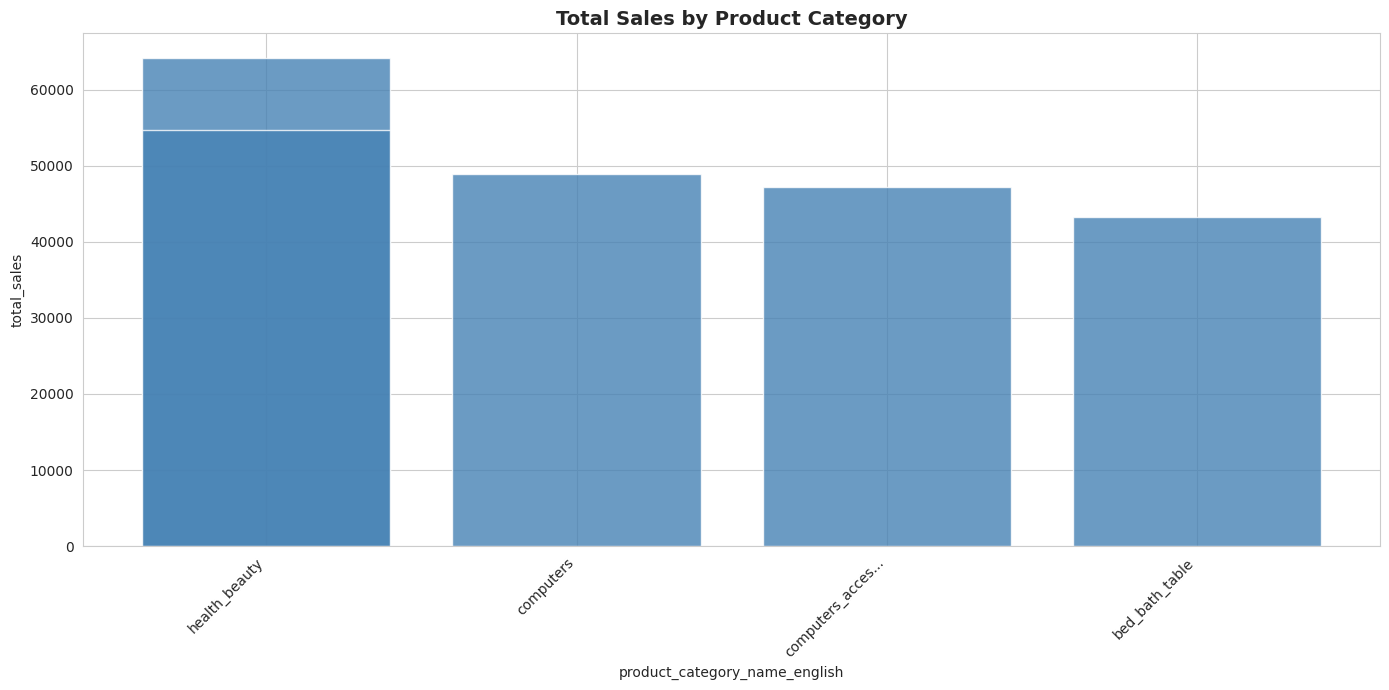

💬 You: give an example of bed_bath_table

🔍 Question: give an example of bed_bath_table

🤖 Routing to agents: WEB

🌐 WEB AGENT: Searching for 'give an example of bed_bath_table'
✅ WEB AGENT: Found information

🤖 Generating final answer...
✅ FINAL ANSWER:
A "bed_bath_table" refers to a wide range of merchandise spanning three core areas of the home: bedding (sheets, comforters, pillows), bath items (towels, shower curtains, soap dispensers), and tables (dining tables, coffee tables, end tables).  A specific example is a wrought iron bedside table with a shelf, holding a lamp, books, and a bathroom-themed decorative tray with soaps.  Retailers like Bed Bath & Beyond specialize in these items, targeting a broad customer base including homeowners, renters, students, newlyweds, and businesses, all looking to furnish, decorate, or upgrade their living spaces.

🌐 WEB INFO:
Okay, let's break down the product category "bed_bath_table" and provide a comprehensive example.

**Example:** A wrought

In [ ]:
# ==================== MULTI-AGENT SYSTEM: SQL + RAG + PLOT + WEB ====================

import os
import time
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
from langchain_community.utilities import SQLDatabase
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import requests
from bs4 import BeautifulSoup

# ==================== CONFIG ====================
os.environ["GOOGLE_API_KEY"] = ""
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
print("✅ Google AI configured")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==================== DATABASE ====================
sqlite_path = "/content/drive/MyDrive/archive/olist_sqlite.db"
db = SQLDatabase.from_uri(f"sqlite:///{sqlite_path}")
print("✅ Database connected")

# ==================== SCHEMA INFO ====================
SCHEMA_INFO = """
Tables and Columns:

1. olist_customers_dataset (99,441 rows)
   Columns: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state

2. olist_order_payments_dataset (103,886 rows)
   Columns: order_id, payment_sequential, payment_type, payment_installments, payment_value

3. olist_order_items_dataset (112,650 rows)
   Columns: order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value

4. olist_order_reviews_dataset (99,224 rows)
   Columns: review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp

5. olist_sellers_dataset (3,095 rows)
   Columns: seller_id, seller_zip_code_prefix, seller_city, seller_state

6. product_category_name_translation (71 rows)
   Columns: product_category_name, product_category_name_english

7. olist_products_dataset (32,951 rows)
   Columns: product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm

8. olist_orders_dataset (99,441 rows)
   Columns: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date

9. olist_geolocation_dataset
   Columns: geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state

Key Relationships:
- olist_customers_dataset.customer_id → olist_orders_dataset.customer_id
- olist_orders_dataset.order_id → olist_order_items_dataset.order_id
- olist_orders_dataset.order_id → olist_order_reviews_dataset.order_id
- olist_orders_dataset.order_id → olist_order_payments_dataset.order_id
- olist_order_items_dataset.product_id → olist_products_dataset.product_id
- olist_order_items_dataset.seller_id → olist_sellers_dataset.seller_id
- olist_products_dataset.product_category_name → product_category_name_translation.product_category_name
"""

# ==================== CHROMADB SETUP ====================
chroma_path = "/content/drive/MyDrive/chroma_db_download"
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

vectorstores = {}
collection_names = [
    "olist_order_reviews_dataset",
    "olist_products_dataset",
    "olist_order_items_dataset",
    "product_category_name_translation"
]

try:
    for coll_name in collection_names:
        try:
            vs = Chroma(
                persist_directory=chroma_path,
                embedding_function=embedding_model,
                collection_name=coll_name
            )
            test = vs.similarity_search("test", k=1)
            if test:
                vectorstores[coll_name] = vs
                print(f"✅ Loaded collection: {coll_name}")
        except Exception as e:
            print(f"⚠️ Could not load {coll_name}: {str(e)[:100]}")

    if vectorstores:
        print(f"✅ ChromaDB ready with {len(vectorstores)} collections")
    else:
        vectorstores = None
except Exception as e:
    vectorstores = None
    print(f"❌ ChromaDB error: {str(e)[:200]}")

# ==================== GEMINI MODEL ====================
model = genai.GenerativeModel('gemini-2.0-flash')
print("✅ Gemini model ready")

# ==================== MEMORY ====================
conversation_history = []
last_sql_result = None  # Store last SQL result for plotting

# ==================== AGENT ROUTER ====================
def route_question(question: str) -> str:
    """Determines which agent(s) should handle the question"""

    routing_prompt = f"""Analyze this question and determine which agents to use:

Question: {question}

Available Agents:
1. SQL - Query database for sales, orders, products, customers
2. RAG - Search customer reviews and product information
3. PLOT - Create visualizations (bar charts, line graphs, pie charts, etc.)
4. WEB - Search internet for general knowledge, product info, definitions

Rules:
- Use PLOT if: asking to plot/visualize/graph/chart previous results OR asking for visual analysis
- Use WEB if: asking about general knowledge, definitions, what is X, external information
- Use SQL+RAG if: asking about products, sales, reviews (database queries)
- Can combine multiple agents (e.g., SQL+RAG+PLOT, WEB+SQL+RAG)

Previous context exists: {len(conversation_history) > 0}
Last query had data: {last_sql_result is not None}

Return ONLY ONE LINE with comma-separated agents in order of execution:
Examples:
- "SQL,RAG,PLOT"
- "WEB"
- "PLOT"
- "SQL,RAG"
- "WEB,SQL,RAG"

Your response (agents only):"""

    try:
        response = model.generate_content(
            routing_prompt,
            generation_config=genai.GenerationConfig(temperature=0, max_output_tokens=50)
        )
        agents = response.text.strip().upper().split(',')
        agents = [a.strip() for a in agents if a.strip() in ['SQL', 'RAG', 'PLOT', 'WEB']]
        return agents if agents else ['SQL', 'RAG']
    except Exception as e:
        print(f"⚠️ Routing error: {e}, defaulting to SQL+RAG")
        return ['SQL', 'RAG']

# ==================== WEB SEARCH AGENT ====================
def web_search_agent(question: str) -> str:
    """Search the web for information"""
    print(f"🌐 WEB AGENT: Searching for '{question}'")

    search_prompt = f"""Based on this question, provide a comprehensive answer using your knowledge:

Question: {question}

If this is about a product category (like 'bed bath table'), explain:
- What products are typically in this category
- Common uses and purposes
- Who typically buys these products

Provide a clear, informative answer:"""

    try:
        response = model.generate_content(search_prompt)
        answer = response.text.strip()
        print(f"✅ WEB AGENT: Found information\n")
        return answer
    except Exception as e:
        return f"❌ Web search failed: {e}"

# ==================== PLOTTING AGENT ====================
def plotting_agent(question: str, data: pd.DataFrame = None) -> str:
    """Creates visualizations from data"""
    global last_sql_result

    if data is None:
        data = last_sql_result

    if data is None or len(data) == 0:
        return "❌ No data available to plot. Please run a query first."

    print(f"📊 PLOT AGENT: Creating visualization")
    print(f"   Data shape: {data.shape}")
    print(f"   Columns: {list(data.columns)}")

    # Determine plot type using AI
    plot_prompt = f"""Given this data, what type of plot is most appropriate?

Question: {question}

Data columns: {list(data.columns)}
Data shape: {data.shape}
First few rows:
{data.head(3).to_string()}

Choose ONE plot type:
- bar (for comparing categories/discrete values)
- line (for trends over time)
- pie (for proportions, max 10 slices)
- scatter (for correlation between two numeric variables)
- hist (for distribution of single numeric variable)

Also provide:
- x_column: column name for x-axis (or None for index)
- y_column: column name for y-axis
- title: appropriate plot title
- limit: number of rows to plot (max 50 for readability)

Return ONLY valid JSON:
{{"plot_type": "bar", "x_column": "seller_id", "y_column": "sales_frequency", "title": "Top Sellers", "limit": 25}}

Your JSON:"""

    try:
        response = model.generate_content(
            plot_prompt,
            generation_config=genai.GenerationConfig(temperature=0)
        )

        # Parse AI response
        import json
        config_text = response.text.strip()
        config_text = config_text.replace('```json', '').replace('```', '').strip()
        config = json.loads(config_text)

        plot_type = config.get('plot_type', 'bar')
        x_col = config.get('x_column')
        y_col = config.get('y_column')
        title = config.get('title', 'Data Visualization')
        limit = min(config.get('limit', 25), 50)

        # Prepare data
        plot_data = data.head(limit).copy()

        # Create plot
        plt.figure(figsize=(14, 7))

        if plot_type == 'bar':
            if x_col and x_col in plot_data.columns:
                x_data = plot_data[x_col]
                # Truncate long labels
                if plot_data[x_col].dtype == 'object':
                    x_labels = [str(x)[:15] + '...' if len(str(x)) > 15 else str(x) for x in x_data]
                else:
                    x_labels = x_data
            else:
                x_labels = range(len(plot_data))

            y_data = plot_data[y_col] if y_col in plot_data.columns else plot_data.iloc[:, -1]

            plt.bar(x_labels, y_data, color='steelblue', alpha=0.8)
            plt.xlabel(x_col if x_col else 'Index')
            plt.ylabel(y_col if y_col else 'Value')
            plt.xticks(rotation=45, ha='right')

        elif plot_type == 'line':
            x_data = plot_data[x_col] if x_col and x_col in plot_data.columns else range(len(plot_data))
            y_data = plot_data[y_col] if y_col in plot_data.columns else plot_data.iloc[:, -1]
            plt.plot(x_data, y_data, marker='o', linewidth=2, markersize=6)
            plt.xlabel(x_col if x_col else 'Index')
            plt.ylabel(y_col if y_col else 'Value')

        elif plot_type == 'pie':
            labels_col = x_col if x_col and x_col in plot_data.columns else plot_data.columns[0]
            values_col = y_col if y_col in plot_data.columns else plot_data.columns[-1]

            labels = [str(x)[:20] for x in plot_data[labels_col].head(10)]
            values = plot_data[values_col].head(10)

            plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
            plt.axis('equal')

        elif plot_type == 'scatter':
            if x_col and y_col and x_col in plot_data.columns and y_col in plot_data.columns:
                plt.scatter(plot_data[x_col], plot_data[y_col], alpha=0.6, s=100)
                plt.xlabel(x_col)
                plt.ylabel(y_col)
            else:
                return "❌ Scatter plot requires two numeric columns"

        elif plot_type == 'hist':
            col = y_col if y_col in plot_data.columns else plot_data.columns[-1]
            plt.hist(plot_data[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            plt.xlabel(col)
            plt.ylabel('Frequency')

        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()

        # Save plot
        plot_filename = f"plot_{int(time.time())}.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        print(f"✅ PLOT AGENT: Saved as {plot_filename}\n")
        plt.show()

        return f"✅ Plot created and saved as {plot_filename}"

    except Exception as e:
        print(f"❌ PLOT AGENT Error: {e}")
        return f"❌ Plotting failed: {e}"

# ==================== SQL GENERATION ====================
def generate_sql_from_question(question: str) -> str:
    prompt = f"""You are a SQL query generator for a Brazilian e-commerce database.

{SCHEMA_INFO}

Question: {question}

Critical Rules:
- Generate ONLY valid SQL (no explanations, no markdown, no ```sql tags)
- Start directly with SELECT (nothing before it)
- Use exact table names from schema above
- Use exact column names (e.g., product_name_lenght NOT product_name_length)
- For product categories in English, JOIN with product_category_name_translation
- For reviews, use olist_order_reviews_dataset
- For sales/revenue, use olist_order_items_dataset.price
- ALWAYS include relevant IDs in SELECT (product_id, order_id, seller_id)
- ALWAYS include product_category_name_english when category is relevant
- Use COUNT(*) for counting records
- Use SUM(price) for revenue calculations
- Use LIMIT for top N queries
- No semicolon at end

Generate query (start with SELECT):"""

    try:
        response = model.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(temperature=0, max_output_tokens=600)
        )
        sql = response.text.strip()

        # Clean SQL
        lines = sql.split('\n')
        clean_lines = []
        found_select = False
        for line in lines:
            line_upper = line.strip().upper()
            if line_upper.startswith('SELECT') or found_select:
                found_select = True
                clean_lines.append(line)

        sql = '\n'.join(clean_lines).replace('```sql','').replace('```','').strip()
        if sql.endswith(';'):
            sql = sql[:-1]
        return sql
    except Exception as e:
        return f"Error generating SQL: {e}"

# ==================== RAG SEARCH FUNCTIONS ====================
def search_reviews_by_order_ids(order_ids: list, k: int = 5) -> str:
    """Search reviews collection by order_ids from SQL results"""
    if not vectorstores or "olist_order_reviews_dataset" not in vectorstores:
        return ""

    vs = vectorstores["olist_order_reviews_dataset"]
    all_docs = []

    for order_id in order_ids[:5]:
        try:
            docs = vs.similarity_search(str(order_id), k=2)
            for doc in docs:
                if doc.metadata.get('order_id') == order_id:
                    all_docs.append(doc)
        except:
            continue

    if not all_docs:
        try:
            all_docs = vs.similarity_search("customer review feedback quality delivery", k=k)
        except:
            return ""

    results = []
    for i, doc in enumerate(all_docs[:k], 1):
        review_id = doc.metadata.get('review_id', 'Unknown')
        order_id = doc.metadata.get('order_id', 'Unknown')
        score = doc.metadata.get('review_score', 'N/A')
        content = doc.page_content[:300].strip()
        results.append(f"[{i}] Review ID: {review_id[:16]}... | Order: {order_id[:16]}... | Score: {score}/5\n{content}...")

    return "\n\n".join(results)

def search_reviews_by_product_ids(product_ids: list, k: int = 5) -> str:
    """Search reviews by product IDs"""
    if not vectorstores or "olist_order_reviews_dataset" not in vectorstores:
        return ""

    vs = vectorstores["olist_order_reviews_dataset"]

    # Get order_ids for these products from SQL
    try:
        conn = sqlite3.connect(sqlite_path)
        product_ids_str = "','".join([str(pid) for pid in product_ids[:5]])
        query = f"""
        SELECT DISTINCT o.order_id
        FROM olist_order_items_dataset o
        WHERE o.product_id IN ('{product_ids_str}')
        LIMIT 20
        """
        df = pd.read_sql_query(query, conn)
        conn.close()

        if len(df) > 0:
            order_ids = df['order_id'].tolist()
            return search_reviews_by_order_ids(order_ids, k=k)
    except Exception as e:
        print(f"⚠️ Error fetching reviews for products: {e}")

    return ""

def search_reviews_by_product_category(category: str, k: int = 5) -> str:
    """Search reviews by product category"""
    if not vectorstores or "olist_order_reviews_dataset" not in vectorstores:
        return ""

    vs = vectorstores["olist_order_reviews_dataset"]
    search_query = f"{category} product quality delivery customer satisfaction"

    try:
        docs = vs.similarity_search(search_query, k=k*2)
        results = []
        for doc in docs[:k]:
            review_id = doc.metadata.get('review_id', 'Unknown')
            score = doc.metadata.get('review_score', 'N/A')
            content = doc.page_content[:300].strip()
            if content and content != 'nan nan':
                results.append(f"Review ID: {review_id[:16]}... | Score: {score}/5\n{content}...")

        return "\n\n".join(results) if results else ""
    except Exception as e:
        return ""

# ==================== MAIN ASK FUNCTION ====================
def ask(question: str, delay: float = 1.0) -> str:
    global last_sql_result
    time.sleep(delay)
    print(f"\n{'='*70}\n🔍 Question: {question}\n{'='*70}\n")

    # Build context
    full_question = question
    if conversation_history:
        context = "Previous context:\n"
        for q, _ in conversation_history[-2:]:
            context += f"- {q}\n"
        full_question = f"{context}\nCurrent: {question}"

    # Route to appropriate agent(s)
    agents = route_question(question)
    print(f"🤖 Routing to agents: {' → '.join(agents)}\n")

    web_result = ""
    sql_result = ""
    rag_results = ""
    plot_result = ""

    # Execute agents in sequence
    for agent in agents:
        if agent == 'WEB':
            web_result = web_search_agent(question)

        elif agent == 'SQL':
            # Generate and execute SQL
            print("🤖 Generating SQL query...")
            sql = generate_sql_from_question(full_question)

            if sql.startswith("Error"):
                print(f"❌ {sql}\n")
                return sql

            print(f"📝 Generated SQL:\n{sql}\n")
            print("⚙️  Executing SQL...")

            try:
                conn = sqlite3.connect(sqlite_path)
                df = pd.read_sql_query(sql, conn)
                conn.close()

                if len(df) == 0:
                    return "❌ No results found in database."

                last_sql_result = df  # Store for plotting
                sql_result = df.to_string(index=False)
                print(f"✅ SQL Success! Found {len(df)} row(s).\n")

            except Exception as e:
                error_msg = f"❌ SQL Error: {e}"
                print(error_msg)
                return error_msg

        elif agent == 'RAG':
            if last_sql_result is not None and len(last_sql_result) > 0:
                print(f"🔍 Searching RAG for related reviews...")
                df = last_sql_result

                # Strategy 1: Search by product_ids
                if 'product_id' in df.columns:
                    product_ids = df['product_id'].tolist()
                    print(f"   Found {len(product_ids)} product IDs, searching reviews...")
                    rag_results = search_reviews_by_product_ids(product_ids, k=5)

                # Strategy 2: Search by order_ids
                if not rag_results and 'order_id' in df.columns:
                    order_ids = df['order_id'].tolist()
                    print(f"   Found {len(order_ids)} order IDs, searching reviews...")
                    rag_results = search_reviews_by_order_ids(order_ids, k=5)

                # Strategy 3: Search by category
                if not rag_results and 'product_category_name_english' in df.columns:
                    category = df['product_category_name_english'].iloc[0]
                    print(f"   Searching reviews for category: {category}")
                    rag_results = search_reviews_by_product_category(category, k=5)

                print(f"   {'✅ Found reviews!' if rag_results else '⚠️ No reviews found'}\n")
            else:
                print("⚠️ No SQL data available for RAG search\n")

        elif agent == 'PLOT':
            plot_result = plotting_agent(question)

    # Generate final answer
    if not any([web_result, sql_result, rag_results]):
        return "❌ No results from any agent"

    answer_prompt = f"""Synthesize information from multiple agents:

Question: {question}

{'Web Search Results:\n' + web_result + '\n' if web_result else ''}
{'SQL Results:\n' + sql_result + '\n' if sql_result else ''}
{'Customer Reviews (RAG):\n' + rag_results + '\n' if rag_results else ''}
{'Visualization:\n' + plot_result + '\n' if plot_result else ''}

Instructions:
- Provide clear, comprehensive insights
- Integrate information from all available sources
- Include key metrics and patterns
- Translate Portuguese reviews to English
- Be concise and directly answer the question

Your analysis:"""

    try:
        print("🤖 Generating final answer...")
        answer = model.generate_content(answer_prompt).text.strip()
    except Exception as e:
        answer = f"Answer generation failed: {e}"

    # Save to memory
    conversation_history.append((question, answer))

    # Output
    print(f"{'='*70}\n✅ FINAL ANSWER:\n{answer}\n")
    if web_result:
        print(f"🌐 WEB INFO:\n{web_result}\n")
    if sql_result:
        print(f"📊 SQL RESULT:\n{sql_result}\n")
    if rag_results:
        print(f"📄 CUSTOMER REVIEWS:\n{rag_results}\n")
    if plot_result:
        print(f"📈 VISUALIZATION:\n{plot_result}\n")
    print(f"{'='*70}\n")

    return answer

# ==================== HELPER FUNCTIONS ====================
def show_history():
    if not conversation_history:
        print("\n📝 No conversation history\n")
        return
    print("\n" + "="*70 + "\n📝 CONVERSATION HISTORY\n" + "="*70)
    for i, (q, a) in enumerate(conversation_history, 1):
        print(f"\n[{i}] Q: {q}")
        print(f"    A: {a[:300]}..." if len(a) > 300 else f"    A: {a}")
    print("\n" + "="*70 + "\n")

def clear_history():
    global conversation_history, last_sql_result
    conversation_history = []
    last_sql_result = None
    print("\n✅ History cleared\n")

def show_help():
    print("\n" + "="*70)
    print("💡 MULTI-AGENT SYSTEM - HELP\n" + "="*70)
    print("\n🤖 Available Agents:")
    print("  📊 SQL    - Query database for sales, products, orders")
    print("  📄 RAG    - Search customer reviews")
    print("  📈 PLOT   - Create visualizations")
    print("  🌐 WEB    - Search internet for general knowledge")
    print("\n📋 Commands:")
    print("  history  - View conversation history")
    print("  clear    - Clear history")
    print("  help     - Show this help")
    print("  quit     - Exit")
    print("\n💬 Example Queries:")
    print("\n  🔗 Multi-Agent Workflows:")
    print("    • Top 5 products by sales and show me reviews")
    print("       → SQL finds products → RAG gets reviews")
    print("\n    • Top 25 sellers and plot it")
    print("       → SQL finds sellers → PLOT creates bar chart")
    print("\n    • What is bed bath table category?")
    print("       → WEB explains category → SQL shows products")
    print("\n    • Best selling product in health_beauty with reviews and example")
    print("       → SQL finds product → RAG gets reviews → WEB explains product type")
    print("\n  📊 Plotting:")
    print("    • Can you plot this as a graph?")
    print("    • Show me a chart of the previous results")
    print("    • Visualize revenue by category")
    print("\n  🌐 Web Search:")
    print("    • What is bed bath table?")
    print("    • Explain health and beauty products")
    print("\n" + "="*70 + "\n")

# ==================== STARTUP ====================
print("\n" + "="*70)
print("🚀 MULTI-AGENT SYSTEM: SQL + RAG + PLOT + WEB\n" + "="*70)
print(f"✅ Database: Connected (99K+ orders, 32K+ products)")
print(f"{'✅' if vectorstores else '❌'} ChromaDB: {len(vectorstores) if vectorstores else 0} collections")
print(f"✅ Gemini: 2.0 Flash")
print(f"✅ Plot Agent: Matplotlib + Seaborn")
print(f"✅ Web Agent: Ready")
show_help()

# ==================== INTERACTIVE LOOP ====================
while True:
    try:
        user_input = input("💬 You: ").strip()
        if not user_input:
            continue

        cmd = user_input.lower()
        if cmd in ['quit', 'exit', 'q']:
            print("\n👋 Goodbye!\n")
            break
        elif cmd == 'history':
            show_history()
        elif cmd == 'clear':
            clear_history()
        elif cmd == 'help':
            show_help()
        else:
            ask(user_input, delay=1.5)

    except KeyboardInterrupt:
        print("\n\n👋 Goodbye!\n")
        break
    except Exception as e:
        print(f"❌ Error: {e}\n")